Graphene unit cell volume: 104.8167866708382 Å³


******** <class 'pyscf.pbc.dft.rks.RKS'> ********
method = RKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-07
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpbdv1y2ti
max_memory 4000 MB (current use 456 MB)
******** PBC SCF flags ********
kpt = [0. 0. 0.]
Exchange divergence treatment (exxdiv) = ewald
Ewald components = 0.0159506725091981, -0.206633516831732, 0.755508832708124
    madelung (= occupied orbital energy shift) = -1.1296519767711803
    Total energy shift due to Ewald probe charge = -1/2 * Nelec*madelung = 4.51860790708
DF object = <pyscf.pbc.df.fft.FFTDF object at 0x7f98eafc08e0>
XC functionals = LDA,VWN
small_rho_cutoff = 1e-07
Uniform grid, mesh = [ 45  45 351]
Set gradient conv threshold to 0.000316228
Initial guess from mi

/home/xhliu/anaconda3/envs/finalenv/lib/python3.10/site-packages/ase/dft/kpoints.py:405: UserWarning: Please do not use (kpts, x, X) = bandpath(...).  Use path = bandpath(...) and then kpts = path.kpts and (x, X, labels) = path.get_linear_kpoint_axis().
  warnings.warn('Please do not use (kpts, x, X) = bandpath(...).  '


Big error detected in the electron number of initial guess density matrix (Ne/cell = 9.84259)!
  This can cause huge error in Fock matrix and lead to instability in SCF for low-dimensional systems.
  DM is normalized wrt the number of electrons 8
nelec by numeric integration = 7.9999999986618855
    CPU time for vxc     14.57 sec, wall time      0.97 sec
Building PBC AO integrals incore
    CPU time for vj and vk     19.78 sec, wall time      1.63 sec
Ewald components = 4.04020723423305, -7.22517593436936, 48.3161280535445
E1 = -105.7918398426246  Ecoul = 51.718459873207166  Exc = -3.157524328151078
init E= -12.0997449441603
    CPU time for initialize scf     64.36 sec, wall time      5.04 sec
  HOMO = -0.531065882544476  LUMO = -0.166820233202364
  mo_energy =
[-1.05742468 -0.60569402 -0.54447837 -0.53106588 -0.16682023 -0.03744037
 -0.02392783  0.08276528]
nelec by numeric integration = 7.999999999273118
    CPU time for vxc     11.11 sec, wall time      0.70 sec
    CPU time for vj

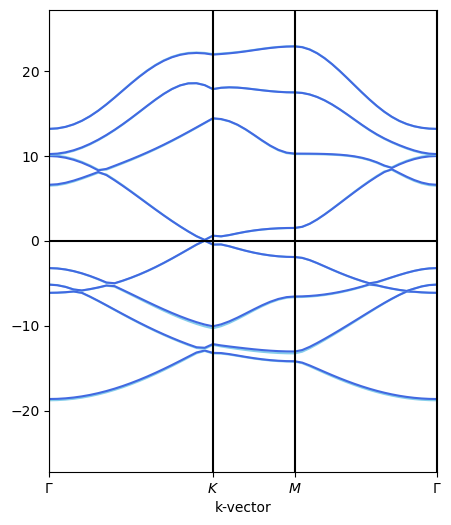

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import pyscf.pbc.gto as pbcgto
import pyscf.pbc.dft as pbcdft

import pyscf.pbc.tools.pyscf_ase as pyscf_ase

from ase.build import graphene
from ase.dft.kpoints import sc_special_points as special_points, get_bandpath

def apply_strain(cell, strain_x, strain_y):
    # Apply strain to the lattice vectors
    strain_matrix = np.array([[1 + strain_x, 0, 0],
                              [0, 1 + strain_y, 0],
                              [0, 0, 1]])
    cell.a = np.dot(cell.a, strain_matrix)
    return cell

# Create graphene structure
graphene_structure = graphene(vacuum=10.0)  # Single-layer graphene with vacuum in z-direction
print(f"Graphene unit cell volume: {graphene_structure.get_volume()} Å³")

# Initialize PySCF periodic cell
cell = pbcgto.Cell()
cell.atom = pyscf_ase.ase_atoms_to_pyscf(graphene_structure)
cell.a = graphene_structure.cell  # Lattice vectors

cell.basis = 'gth-szv'
cell.pseudo = 'gth-pade'
cell.verbose = 5
cell.build(None, None)

# Apply strain to the lattice
strain_x = 0.05  # Example strain in x direction (5%)
strain_y = 0.00  # Example strain in y direction (5%)
cell = apply_strain(cell, strain_x, strain_y)

# Define k-points and band structure path for hexagonal lattice (graphene)
points = special_points['hexagonal']  # Adjusted for hexagonal lattice
G = points['G']
M = points['M']
K = points['K']
band_kpts, kpath, sp_points = get_bandpath([G, K, M, G], graphene_structure.cell, npoints=50)
band_kpts = cell.get_abs_kpts(band_kpts)

# Band structure from Gamma point sampling
mf = pbcdft.RKS(cell)
print(mf.kernel())

e_kn = mf.get_bands(band_kpts)[0]
vbmax = -99
for en in e_kn:
    vb_k = en[cell.nelectron // 2 - 1]
    if vb_k > vbmax:
        vbmax = vb_k
e_kn = [en - vbmax for en in e_kn]

# Band structure from 222 k-point sampling
kmf = pbcdft.KRKS(cell, cell.make_kpts([2, 2, 2]))
print(kmf.kernel())

e_kn_2 = kmf.get_bands(band_kpts)[0]
vbmax = -99
for en in e_kn_2:
    vb_k = en[cell.nelectron // 2 - 1]
    if vb_k > vbmax:
        vbmax = vb_k
e_kn_2 = [en - vbmax for en in e_kn_2]

# Plot band structure
au2ev = 27.21139

emin = -1 * au2ev
emax = 1 * au2ev

plt.figure(figsize=(5, 6))
nbands = cell.nao_nr()
for n in range(nbands):
    plt.plot(kpath, [e[n] * au2ev for e in e_kn], color='#87CEEB')
    plt.plot(kpath, [e[n] * au2ev for e in e_kn_2], color='#4169E1')
for p in sp_points:
    plt.plot([p, p], [emin, emax], 'k-')
plt.plot([0, sp_points[-1]], [0, 0], 'k-')
plt.xticks(sp_points, ['$%s$' % n for n in ['Γ', 'K', 'M', 'Γ']])
plt.axis(xmin=0, xmax=sp_points[-1], ymin=emin, ymax=emax)
plt.xlabel('k-vector')

plt.show()

In [ ]:
# Save the band energies to a .npz file
def save_dft_data(e_kn, e_kn_2, filename="dft_data.npz"):
    # Save both arrays to a .npz file
    np.savez(filename, e_kn=e_kn, e_kn_2=e_kn_2)
    print(f"DFT data saved to {filename}")

# Example usage
save_dft_data(e_kn, e_kn_2, filename="dft_data_x0.05.npz")

In [ ]:
# Load the saved DFT data from a .npz file
def load_dft_data(filename="dft_data_x0.05.npz"):
    data = np.load(filename)
    e_kn = data['e_kn']
    e_kn_2 = data['e_kn_2']
    print(f"DFT data loaded from {filename}")
    return e_kn, e_kn_2

# Example usage
e_kn, e_kn_2 = load_dft_data()
